In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import timm

In [12]:

batch_size = 512
num_workers = 8

model_name = 'vit_base_patch16_224'
pretrained = True
num_classes = 10

device_gpu = 'cuda:0'

label_smoothing = 0.0
learning_rate = 0.001

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = timm.create_model(model_name=model_name, 
                          pretrained=pretrained, 
                          num_classes=num_classes)

device = torch.device(device_gpu if torch.cuda.is_available() else "cpu")
model.to(device)


In [15]:
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [17]:
epochs = 20
training_time = 0
early_stopping = EarlyStopping(patience=5)
losses = []
lrs = []

for epoch in range(epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)
    epoch_duration = time.time() - start_time
    training_time += epoch_duration
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}, Duration: {epoch_duration:.2f} sec')
    
    # Early Stopping 체크
    early_stopping(epoch_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 1, Loss: 2.1663736725340086, Duration: 327.53 sec
Epoch 2, Loss: 1.596431949917151, Duration: 329.41 sec
Epoch 3, Loss: 1.3122388440735486, Duration: 332.16 sec
Epoch 4, Loss: 1.137649840238143, Duration: 330.48 sec
Epoch 5, Loss: 1.0336357859932646, Duration: 332.18 sec
Epoch 6, Loss: 0.7937396162626694, Duration: 329.96 sec
Epoch 7, Loss: 0.6829396328147577, Duration: 330.19 sec
Epoch 8, Loss: 0.5966125623304017, Duration: 331.52 sec
Epoch 9, Loss: 0.49977164000880964, Duration: 331.24 sec
Epoch 10, Loss: 0.38970874706093145, Duration: 331.84 sec
Epoch 11, Loss: 0.20533092183117962, Duration: 331.72 sec
Epoch 12, Loss: 0.13786557286369558, Duration: 330.06 sec
Epoch 13, Loss: 0.10000300426416252, Duration: 331.43 sec
Epoch 14, Loss: 0.07265905165398608, Duration: 330.06 sec
Epoch 15, Loss: 0.05104815013402579, Duration: 329.20 sec
Epoch 16, Loss: 0.035426837069039444, Duration: 332.02 sec
Epoch 17, Loss: 0.033316907282842666, Duration: 330.87 sec
Epoch 18, Loss: 0.0320284018692

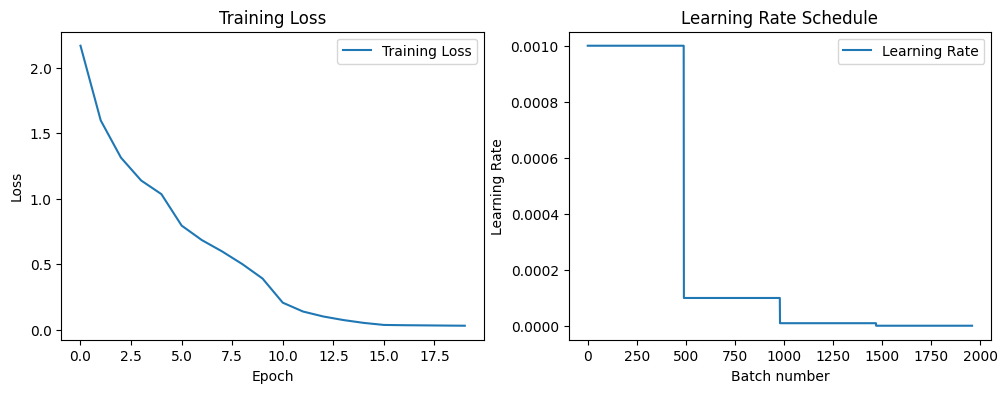

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lrs, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Batch number')
plt.ylabel('Learning Rate')
plt.legend()

plt.show()